In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
# torch.manual_seed(seed=42) 
os.makedirs('./model_para', exist_ok=True)

In [19]:
class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=64):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)

In [20]:
def potential(x,k,l,scale=100):
    poten=-1/x*scale
    return poten-k*(l+1)*l/x**2

In [21]:
def energy(en_level,l,k,scale,device,dtype):
    en_list=[scale**2/(4*k*(i+1)**2) for i in range(en_level)]
    en_list=torch.tensor(en_list,device=device,dtype=dtype)
    return en_list

###### 氢原子能级
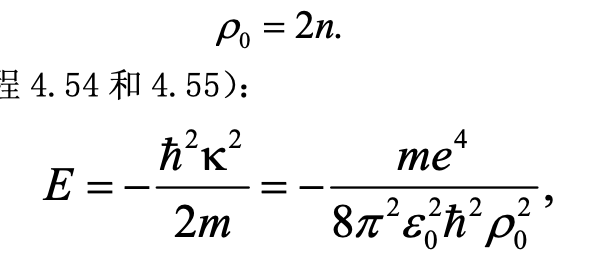
##### 相当于$\alpha=e^2/(4\pi \epsilon_0)=1,E_n=-2m/\hbar^2*\alpha^2/(4n^2)$
##### and $ a_{bohr}=2*k/\alpha, k=\hbar^2/2m $

In [22]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

La=0
Lb =100
L=Lb-La  # domain length
N = 4000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
# 角量子数
l=0
# 控制势函数的大小
scale=10
en_num=20
epoch=1000
lr=0.01
real_en=energy(en_num,l,b_lap,scale,device,dtype)

model=Mynetwork().to(device=device,dtype=dtype)
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=20,threshold=1e-4)
loss_fn=nn.L1Loss()
# Construct the tridiagonal matrix A
diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap

V_diag=potential(grid,b_lap,l,scale)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)
print('initial eigenvalues check:')
print(eigenvalues[:en_num])


initial eigenvalues check:
tensor([-49.2425, -12.4515,  -5.5459,  -3.1220,  -1.9987,  -1.3883,  -1.0201,
         -0.7810,  -0.6171,  -0.4998,  -0.4131,  -0.3470,  -0.2957,  -0.2550,
         -0.2218,  -0.1953,  -0.1729,  -0.1540,  -0.1383,  -0.1241],
       device='cuda:0')


In [23]:

loss_list=[]
init_time=time.time()
for i in range(epoch):
    optimizer.zero_grad()
    V_diag=model(grid)
    A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
    eigenvalues= torch.linalg.eigvalsh(A)
    '''output=NN(input)
    diag=torch.diag(output.flatten())'''
    
    print('\nepoch:',i)
    print(eigenvalues[:en_num])
    print(real_en)
    
    output=eigenvalues[:en_num]
    loss=loss_fn(output,real_en)
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if i%10==0:
        print(f'epoch:{i},loss:{loss},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
    if (i+1)%100==0:torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')
    scheduler.step(loss)
    if optimizer.param_groups[0]["lr"] <= 1.1e-8:break
print('terminal epoch: ',i+1)
torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')



epoch: 0
tensor([-0.2962, -0.2698, -0.2475, -0.2277, -0.2089, -0.1906, -0.1731, -0.1559,
        -0.1389, -0.1232, -0.1066, -0.0902, -0.0744, -0.0589, -0.0419, -0.0254,
        -0.0086,  0.0085,  0.0257,  0.0430], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([-50.0000, -12.5000,  -5.5556,  -3.1250,  -2.0000,  -1.3889,  -1.0204,
         -0.7812,  -0.6173,  -0.5000,  -0.4132,  -0.3472,  -0.2959,  -0.2551,
         -0.2222,  -0.1953,  -0.1730,  -0.1543,  -0.1385,  -0.1250],
       device='cuda:0')
epoch:0,loss:3.872373342514038,time:0.11957502365112305,lr:0.01

epoch: 1
tensor([-20.4486, -19.9921, -19.6184, -19.2881, -18.9862, -18.7048, -18.4394,
        -18.1868, -17.9448, -17.7119, -17.4868, -17.2687, -17.0566, -16.8500,
        -16.6483, -16.4511, -16.2581, -16.0689, -15.8832, -15.7008],
       device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-50.0000, -12.5000,  -5.5556,  -3.1250,  -2.0000,  -1.3889,  -1.0204,
         -0.7812,  -0.6173,  -0.5000,  -0.4132,  -0.3472,  

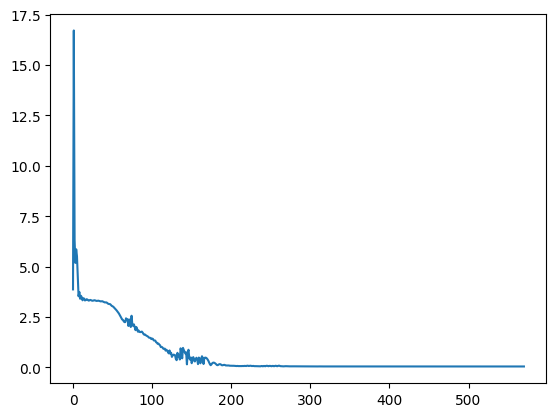

In [24]:
plt.plot(loss_list)
plt.show()

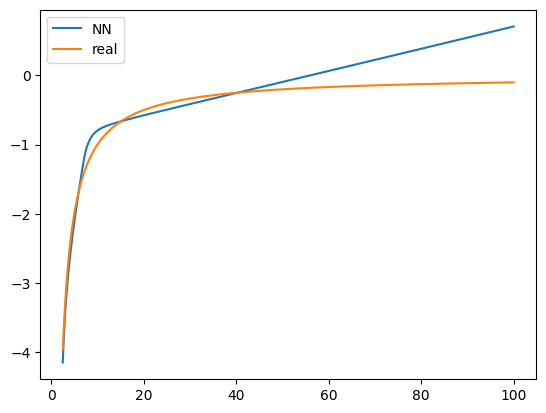

In [25]:
La=0
Lb =100
L=Lb-La  # domain length
N = 4000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
grid=grid[100:]
NN_poten=model(grid)
real_poten=potential(grid,b_lap,l,scale)
NN_poten=NN_poten.cpu().detach().numpy()
real_poten=real_poten.cpu().detach().numpy()
grid=grid.cpu().detach().numpy()
plt.plot(grid,NN_poten,label='NN')
plt.plot(grid,real_poten,label='real')
plt.legend()
plt.show()
